# <div style="text-align: center">Phase and Magnitude Detection Demo </div>
<div style="text-align: center">AWESEM Signal Processing </div>
<br>
<div style="text-align: center">Erick Blankenberg, 6/26/2019 </div>

---
## <div style="text-align: center">Introduction </div>
The goal of the AWESEM project is to construct a low cost mechanical scanning imaging system from commonly available parts. 

The goal of this document is to demonstrate a method for characterizing the mechanical stage of the device purely from scanned data of a Ronchi square mesh that could be obtained from the completed device without additional external test equipment.

If we assume that the scanning system can be modelled as a linear and time-invariant (LTI) system than we can create a useful model, the transfer function of the system, from its frequency-domain response. This model will allow us to predict the motion of the stage for an arbitrary driving waveform.

---
## <div style="text-align: center">System Model </div>

The scanning system consists of four parts. A DAC and a power amplifier which act as an arbitrary waveform generator, the driver coil which is driven by this waveform generator and which drives the mechanical stage. The mechanical stage itself, and a photodiode with amplifier that is sampled by the ADC of the microcontroller.
<br>
<br>
TODO diagrams for each sub-component, measurements and preliminary frequency-response assumptions. Justification + links for simplifications made

---
## <div style="text-align: center">Reconstruction Approach </div>
<br>
<br>
To sample the frequency-domain response, we scanned a standard grid pattern with a sinusoidal driving waveform over a range of frequencies. As we assumed that the system was LTI, we assumed that the displacement waveform would also be sinusoidal. Below we have simulated what a single scan might look like when the displacement waveform is a delayed inverted cosine.

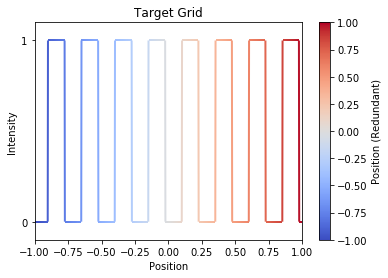

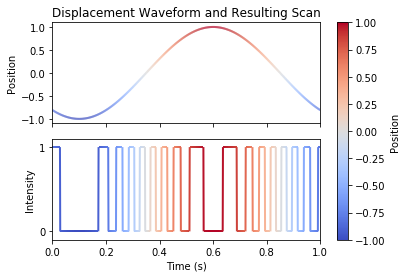

In [59]:
import numpy
from   matplotlib import cm
from   matplotlib import pyplot
from   matplotlib.collections import LineCollection
from   matplotlib.colors import ListedColormap

GridPeriod  = 0.25 # Width of grid period
GridDensity = 0.5  # How much of the grid renders high
GridOffset  = 0.1 # How far to shift grid
isGrid = lambda pos: (((pos - GridOffset) % GridPeriod) < (GridPeriod * GridDensity))

# Construct simple sinusoidal displacement
times           = numpy.linspace(0, 1, num = 1000)
sineMag         = 1.0 
sineOffset      = 0.1 # Shifted seconds
sinDisplacement = -numpy.cos((times - sineOffset) * 2.0 * numpy.pi) * sineMag

# Plots target grid over range for reference
norm               = pyplot.Normalize(-sineMag, sineMag) # Standard colors used for later
gridRange  = numpy.linspace(sinDisplacement.min(), sinDisplacement.max(), num = 1000)
gridValues = isGrid(gridRange)
gridFig, gridGraph = pyplot.subplots(1, 1, sharex = True, sharey = True)
gridPoints         = numpy.array([gridRange, gridValues]).T.reshape(-1, 1, 2)
gridSegments       = numpy.concatenate([gridPoints[:-1], gridPoints[1:]], axis=1)
gridLineCollection = LineCollection(gridSegments, cmap = 'coolwarm', norm = norm)
gridLineCollection.set_array(gridRange)
gridLineCollection.set_linewidth(2)
line = gridGraph.add_collection(gridLineCollection)
pyplot.title('Grid Cells')
pyplot.xlabel('Position')
pyplot.ylabel('Intensity')
pyplot.title('Target Grid')
colorBar = gridFig.colorbar(line, ax = gridGraph);
colorBar.set_label('Position (Redundant)')
pyplot.ylim((-0.1, 1.1));
pyplot.yticks([0, 1])
pyplot.xlim((-1, 1));
pyplot.show()

# Plots sinusoidal displacement and theoretical scan
# > Plots sine
fig, axes = pyplot.subplots(2, 1, sharex = True)
sineGraph = axes[0]
sinPoints          = numpy.array([times, sinDisplacement]).T.reshape(-1, 1, 2)
sinSegments        = numpy.concatenate([sinPoints[:-1], sinPoints[1:]], axis=1)
sineLineCollection = LineCollection(sinSegments, cmap = 'coolwarm', norm = norm)
sineLineCollection.set_array(sinDisplacement)
sineLineCollection.set_linewidth(2)
line = sineGraph.add_collection(sineLineCollection)
sineGraph.title.set_text('Displacement Waveform and Resulting Scan')
sineGraph.set_ylabel('Position')
sineGraph.set_ylim((-sineMag * 1.1, sineMag * 1.1));
# > Puts in scan data 
sinGridValues = isGrid(sinDisplacement)
sinGridGraph = axes[1]
sinGridPoints         = numpy.array([times, sinGridValues]).T.reshape(-1, 1, 2)
sinGridSegments       = numpy.concatenate([sinGridPoints[:-1], sinGridPoints[1:]], axis=1)
sinGridLineCollection = LineCollection(sinGridSegments, cmap = 'coolwarm', norm = norm)
sinGridLineCollection.set_array(sinDisplacement)
sinGridLineCollection.set_linewidth(2)
line = sinGridGraph.add_collection(sinGridLineCollection)
sinGridGraph.set_xlabel('Time (s)')
sinGridGraph.set_ylabel('Intensity')
sinGridGraph.set_ylim((-0.1, 1.1));
pyplot.yticks([0, 1])
pyplot.subplots_adjust(hspace = 0.15)
# > Creates colorbar on side
colorBar = fig.colorbar(line, ax = axes.ravel().tolist());
colorBar.set_label('Position')
pyplot.show()

For each driving frequency we need to find the phase and magnitude of the resulting displacement waveform relative to the driving waveform.
<br>
<br>
To identify the phase offset, we took advantage of the presumed symmetry of the response waveform. If we assume that the response displacement waveform is a sinusoidal wave than there will be an axis of symmetry at each crest and trough of the waveform. As the displacement is symmetric about these points of interest, we expect that the scan data, assumed to be a function of position, will also exhibit this symmetry as seen in the graph above which will allow us to identify the troughs and crests of the displacement waveform indirectly. Unfortunately, as both troughs and crests exhibit this symmetry, we cannot distinguish between them without additional information. 
<br>
<br>
For now, we will assume that the phase delay of the displacement waveform relative to the driving waveform is less than $\pi$. The rational behind this assumption is that if we assume that the behavior of the spring-mass-damper system is the first to manifest as we increase in frequency, that is if there are no other poles with lower corner frequences in our system, than our phase delay will initially be zero and transition to $\pi$ after we pass the natural frequency of the spring-mass-damper. The phase delay may evolve further at higher frequeunces but from our earlier system model and measurements it seems that this will occur in ranges beyond our measurement capability. If our assumption about the phase delay of the displacement is incorrect, that is if the phase delay can exceed $\pi$ in our range of interest, than we will observe a discontinuity as our calculated phase will wrap back around as the phase delay progresses. Therefore, as our driving waveform is an inverted cosine, we will assume that the first axis of symmetry corresponds to a trough point.
<br>
<br>
Once we have identified the position corresponding to the trough point, we can map our time-stamped data to relative position and determine the scale of the resulting image by identifying useful landmarks. Once we have established the phase delay and scale over a range of frequencies we can find the values of unknown parameters in our system model that best fit this data.

---
## <div style="text-align: center">Implementation </div>
In the first portion below we import one limited "Modern Art" image to be analyzed. 
<br>
<br>
This image is arranged so that the fast axis, the axis to be corrected, is parallel to the horizontal axis of the image. The slow axis is parallel to the vertical axis of the image. 
<br>
<br>
We are assuming that the response along the fast axis is independant of displacement along the slow axis. We are also assuming that the difference in frequency between the slow and fast axis is great enough that the displacement of the scans along the fast axis can be considered orthogonal to the motion of the slow axis, that is we are assuming that each row of the image represents a true cross section of the grid.
<br>
<br>
Note that the driving waveform in this case is an inverted cosine, a sine function with a phase delay of $\frac{ \pi}{2}$.

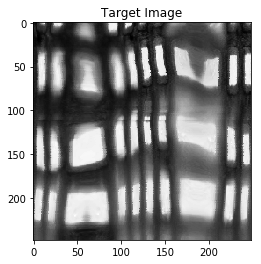

In [153]:
# Libraries
import ProcessingFuncs
from   math import floor 
import numpy
import imageio
from   scipy       import ndimage
from   scipy       import misc
from   scipy       import signal
from skimage       import data
from skimage.color import rgb2gray
import skimage.filters as filters
from   matplotlib import cm
from   matplotlib import pyplot

# Imports limited "Modern Art" image.

originalImage  = numpy.rot90(imageio.imread('ExCapture.bmp'))
originalImage  = originalImage[1:-1, 1:-1] # Sometimes edges are cut off in scans
grayScaleImage = rgb2gray(originalImage)
pyplot.imshow(grayScaleImage, cmap= pyplot.cm.gray)
pyplot.title('Target Image')
pyplot.show()

Our first step is to find the phase offset.
<br>
<br>
The approach below uses the simple symmetry detection method along a known coordinate axis described in https://www.eurasip.org/Proceedings/Eusipco/Eusipco2017/papers/1570347823.pdf. This method TODO
<br>
<br>
In this case we are interested in the overall symmetry of the modern art image along the target coordinate axis with wraparound as the driving sinusoidal waveform is periodic and the assumed response waveform is as well.
<br>
<br>
Once we identify the axis of symmetry of this image we have effectively found the trough or crest of the response waveform but cannot from this image alone discern which of the two we have identified. For now we will assume that the closest mirror axis, that is the first axis that occurs in the response waveform relative to the start of the driving waveform, is a trough as our driving waveform's origin consists of a trough and we expect a small phase displacement. 
<br>
<br>
We can re-investigate this later once we have more frequency response information.

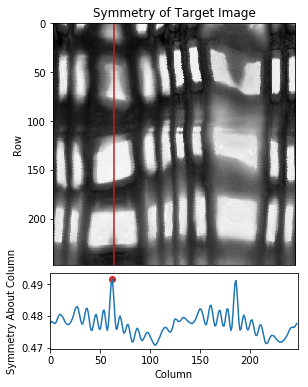

In [151]:
targetImage = grayScaleImage
# Evaluates symmetry along rows for the given patch

symmetryVals = ProcessingFuncs.evaluatePatchVerticalSymmetry(targetImage)
troughPhase = ProcessingFuncs.getSymmetryPhaseFromVals(symmetryVals)
maxIndex = (troughPhase / (2.0 * numpy.pi)) * max(symmetryVals.shape)

symFig   = pyplot.figure(figsize = (6, 6))
symGrid  = pyplot.GridSpec(4, 4, hspace = 0.1, wspace = 0.2)
symmesAx = symFig.add_subplot(symGrid[-1, 1:], sharex = imageAx, ylabel = 'Symmetry About Column', xlabel = 'Column', xlim = (0, symmetryVals.shape[0]))
imageAx  = symFig.add_subplot(symGrid[:-1, 1:], ylabel = 'Row')
imageAx.get_xaxis().set_visible(False)
pyplot.title('Symmetry of Target Image')

# Shows symmetry measure as a function of row index
symmesAx.plot(symmetryVals, label = 'Symmetry Measure')
symmesAx.scatter(maxIndex, symmetryVals[int(maxIndex)], label = 'Maximum', color = "tab:Red")

# Plots image with maximum symmetry lines marked
imageAx.imshow(targetImage, cmap= pyplot.cm.gray, zorder = 1)
ymin, ymax = pyplot.gca().get_ybound()
imageAx.plot([maxIndex, maxIndex], [ymin, ymax], color = 'fireBrick', zorder = 2)
pyplot.show()



We now know the time offset corresponding to what we assume to be a trough in a sinusoidal displacement waveform. We can now correct for the sinusoidal motion of the scan.
<br>
<br>
The data before and after the trough represent samples from the same points in space and ideally should generate the same image. The images below are both generated with the left hand side starting at the trough of the displacement and the right hand side ending at the crest of the displacement for easy comparison.

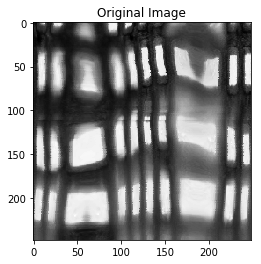

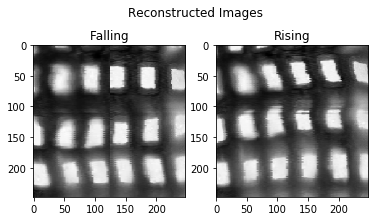

In [142]:
# Plots image and assumed displacement waveform
pyplot.imshow(targetImage, cmap= pyplot.cm.gray)
pyplot.title('Original Image')
pyplot.show()

# We are going to use the crest as a reference point at zero and assume a cosine displacement waveform
imageRising, imageFalling = ProcessingFuncs.resampleVerticalDistortion(targetImage, troughPhase)
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Reconstructed Images', y = 0.9)
axis[0].set_title('Falling')
axis[0].imshow(imageFalling, cmap= pyplot.cm.gray)
axis[1].set_title('Rising')
axis[1].imshow(imageRising, cmap= pyplot.cm.gray)
pyplot.show()

TODO add color-coded plots directly under each image and the original image to illustrate what "falling" and "rising" mean in the context of the original image
<br>
<br>
Now that we have (hopefully) created a faithful reconstruction of the scanned data along the horizontal axis, we can identify the scale of the image by finding the period of the grid along the reconstructed axis.
<br>
<br>
*Note that we did not preform any analysis or attempt any reconstruction of the vertical axis of the image, for the purposes of characterizing one axis of the stage we are only concerned with the horizontal axis.*

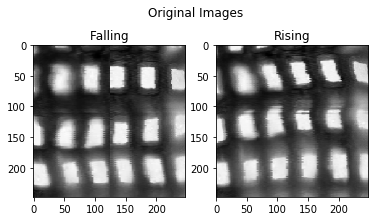

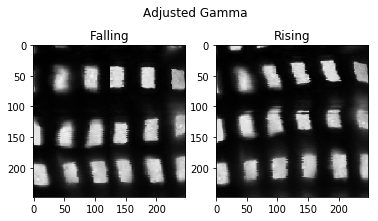

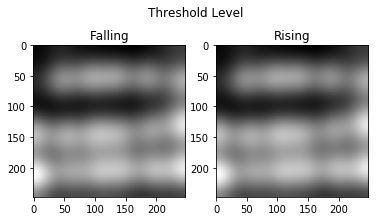

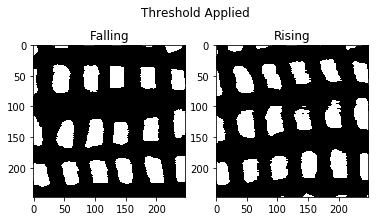

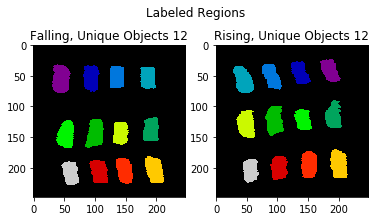

In [135]:
from skimage.exposure     import adjust_gamma
from skimage.segmentation import clear_border
import skimage.filters as filters
from   scipy import ndimage

# Applies thresholding to image to isolate bars
# > Source images
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Original Images', y = 0.9)
axis[0].set_title('Falling')
axis[0].imshow(imageFalling, cmap= pyplot.cm.gray)
axis[1].set_title('Rising')
axis[1].imshow(imageRising, cmap= pyplot.cm.gray)

# > Adjusts gamma to isolate bright locations
imageFallingAdjusted = adjust_gamma(imageFalling, gamma = 5)
imageRisingAdjusted = adjust_gamma(imageRising, gamma = 5)
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Adjusted Gamma', y = 0.9)
axis[0].set_title('Falling')
axis[0].imshow(imageFallingAdjusted, cmap= pyplot.cm.gray)
axis[1].set_title('Rising')
axis[1].imshow(imageRisingAdjusted, cmap= pyplot.cm.gray)

# > Uses local thresholding to normalize to regional variances in brightness
thresholdedFallingVals = filters.threshold_local(imageFallingAdjusted, block_size = 125)
thresholdedRisingVals = filters.threshold_local(imageFallingAdjusted, block_size = 125)
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Threshold Level', y = 0.9)
axis[0].set_title('Falling')
axis[0].imshow(thresholdedFallingVals, cmap= pyplot.cm.gray)
axis[1].set_title('Rising')
axis[1].imshow(thresholdedRisingVals, cmap= pyplot.cm.gray)

# > Applies Threshold
thresholdedFallingImage  = imageFallingAdjusted > thresholdedFallingVals
thresholdedRisingImage = imageRisingAdjusted  > thresholdedRisingVals
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Threshold Applied', y = 0.9)
axis[0].set_title('Falling')
axis[0].imshow(thresholdedFallingImage, cmap= pyplot.cm.gray)
axis[1].set_title('Rising')
axis[1].imshow(thresholdedRisingImage, cmap= pyplot.cm.gray)

# Remove small unconnected regions and occluded components
thresholdedFallingImageCleared = clear_border(thresholdedFallingImage)
thresholdedRisingImageCleared  = clear_border(thresholdedRisingImage)
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Removed Occluded Objects', y = 0.9)
axis[0].set_title('Falling')
axis[0].imshow(thresholdedFallingImageCleared, cmap= pyplot.cm.gray)
axis[1].set_title('Rising')
axis[1].imshow(thresholdedRisingImageCleared, cmap= pyplot.cm.gray)

# > Removes salt and pepper
thresholdedFallingImageCleaned = ndimage.binary_closing(ndimage.binary_opening(thresholdedFallingImageCleared)) 
thresholdedRisingImageCleaned = ndimage.binary_closing(ndimage.binary_opening(thresholdedRisingImageCleared)) 
pyplot.imshow(thresholdedImage, cmap= pyplot.cm.gray)
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Removed Salt and Pepper', y = 0.9)
axis[0].set_title('Falling')
axis[0].imshow(thresholdedFallingImageCleaned, cmap= pyplot.cm.gray)
axis[1].set_title('Rising')
axis[1].imshow(thresholdedRisingImageCleaned, cmap= pyplot.cm.gray)

# > Identifies bars
fallingLabeled, fallingLabeledNum = ndimage.label(thresholdedFallingImageCleaned)
risingLabeled, risingLabeledNum = ndimage.label(thresholdedRisingImageCleaned)
pyplot.imshow(labeled_bars, cmap = pyplot.cm.nipy_spectral)
fig, axis = pyplot.subplots(1, 2)
fig.suptitle('Labeled Regions', y = 0.9)
axis[0].set_title('Falling, Unique Objects %s' % (fallingLabeledNum))
axis[0].imshow(fallingLabeled, cmap = pyplot.cm.nipy_spectral)
axis[1].set_title('Rising, Unique Objects %s' % (risingLabeledNum))
axis[1].imshow(risingLabeled, cmap = pyplot.cm.nipy_spectral)
pyplot.show()


Now that we have identified the grid features, we can establish the scale of the image.
<br>
<br>
Ideally, each row of our images above should represent a cross section of the target grid. 
<br>
<br>
There are many ways that we could analyze each row to establish the scale but two easy ways come to mind. First, as we know the period of the grid we can use this as a reference and identify scale by looking at the period of the cells, that is the difference between consecutive cell centroids within each row. Second, if we know the physical width of these cells we can find the width of the cells within every row of the image and scale accordingly.
<br>
<br>
Considering TODO . As we are considering each row in isolation there may be rows where there are no cells or only one cell present which will not contribute information. TODO looking at cell width is bad b/c laser spot size is large + variable, need to replace all images where we only have one cell visible with ones where we have at least two so that we can use the grid spacing instead.

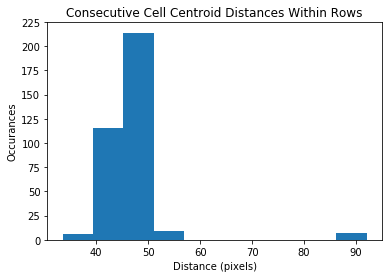

In [149]:
from numpy import concatenate
from numpy import zeros

rowStats = ProcessingFuncs.getLabelHorizontalSpacings(labeled_bars, numBars)

# Plots histogram for spacings between all objects
allStats = concatenate(rowStats)
pyplot.hist(allStats)
pyplot.title("Consecutive Cell Centroid Distances Within Rows")
pyplot.ylabel('Occurances')
pyplot.xlabel('Distance (pixels)')
pyplot.show()

As a result we have the following:

In [10]:
meanWidth = numpy.mean(allStats)

print("Mean Value: %s" % (meanWidth))

PhysicalCellWidth = 50.8 # Microns

MicronsPerPixel = PhysicalCellWidth / meanWidth
MicronsDimensions = MicronsPerPixel * numpy.asarray(targetImage.shape)

print("Image dimensions in microns: %s" % (MicronsDimensions))


Mean Value: 46.92427884615384
Image dimensions in microns: [268.48361466 268.48361466]


# <div style="text-align: center">Stage Calibration </div>

---
Now that we have a method for evaluating the phase distortion and response magnitude of the mechanical stage from data collected with a sinusoidal driving waveform we can evaluate these values for samples collected over a wide frequency range to characterize the stage.

Below we import images over a range of interest frequencies and identify the phase and magnitude of each to build a frequency response curve that we then fit to an easy to evaluate model for future use.


  0%|          | 0/90 [00:00<?, ?it/s]

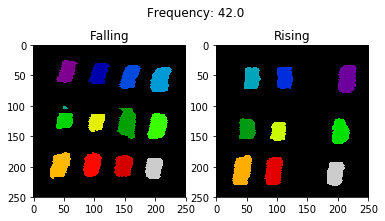


  1%|          | 1/90 [00:00<01:02,  1.42it/s]

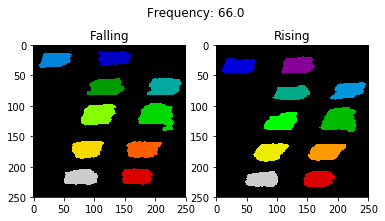


  2%|▏         | 2/90 [00:01<01:02,  1.42it/s]

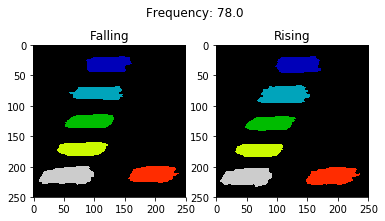


  3%|▎         | 3/90 [00:02<01:02,  1.40it/s]

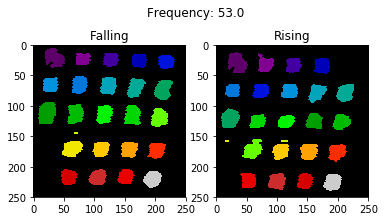


  4%|▍         | 4/90 [00:02<01:02,  1.37it/s]

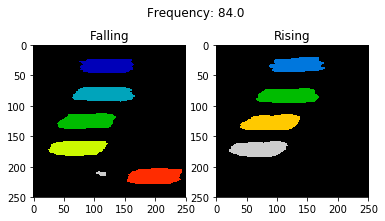


  6%|▌         | 5/90 [00:03<01:01,  1.39it/s]

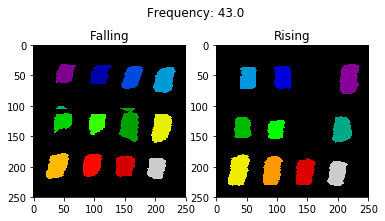


  7%|▋         | 6/90 [00:04<01:00,  1.39it/s]

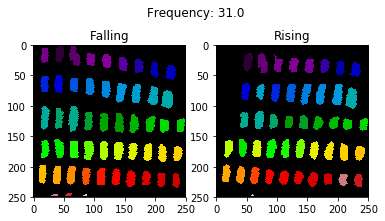


  8%|▊         | 7/90 [00:05<01:03,  1.31it/s]

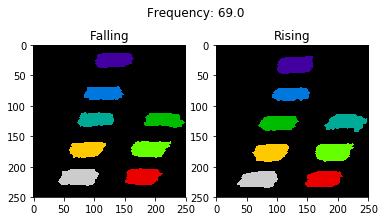


  9%|▉         | 8/90 [00:05<01:01,  1.34it/s]

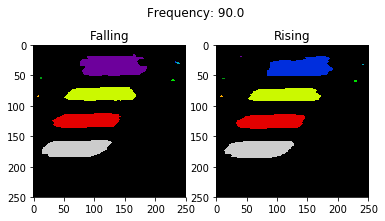


 10%|█         | 9/90 [00:06<00:59,  1.35it/s]

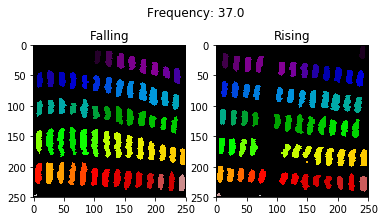


 11%|█         | 10/90 [00:07<01:04,  1.25it/s]

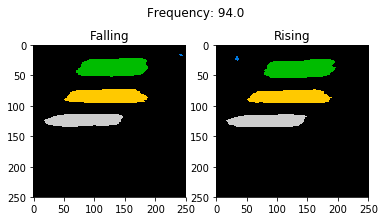


 12%|█▏        | 11/90 [00:08<01:00,  1.31it/s]

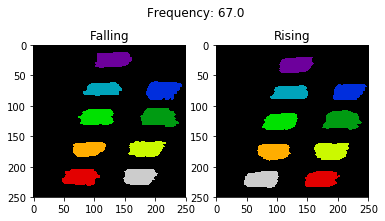


 13%|█▎        | 12/90 [00:08<00:57,  1.35it/s]

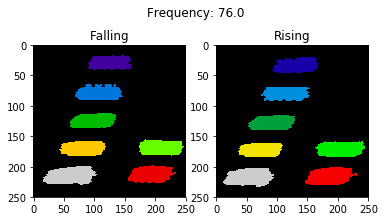


 14%|█▍        | 13/90 [00:09<00:56,  1.37it/s]

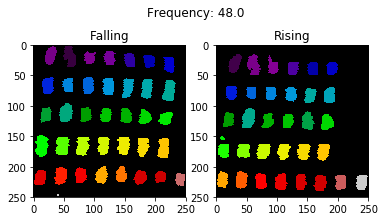


 16%|█▌        | 14/90 [00:10<00:58,  1.31it/s]

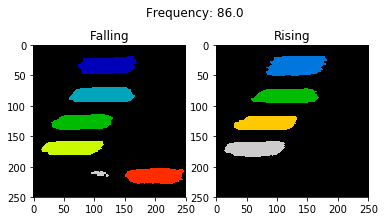


 17%|█▋        | 15/90 [00:11<00:55,  1.36it/s]

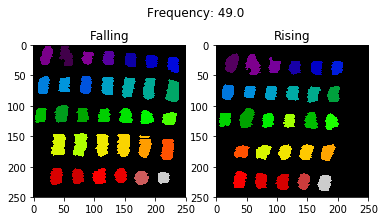


 18%|█▊        | 16/90 [00:11<00:55,  1.33it/s]

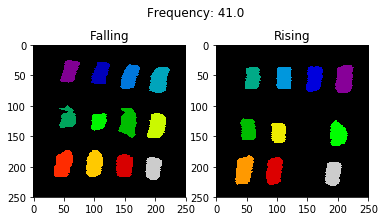


 19%|█▉        | 17/90 [00:12<00:53,  1.36it/s]

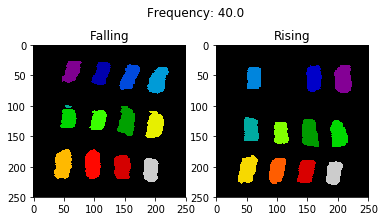


 20%|██        | 18/90 [00:13<00:52,  1.37it/s]

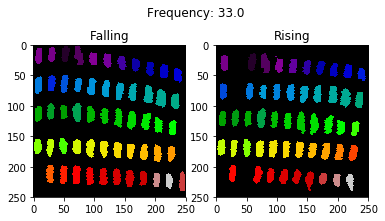


 21%|██        | 19/90 [00:14<00:54,  1.29it/s]

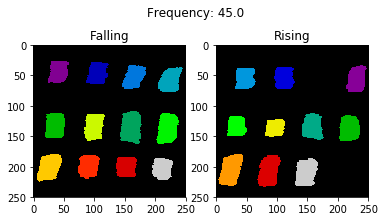


 22%|██▏       | 20/90 [00:14<00:53,  1.32it/s]

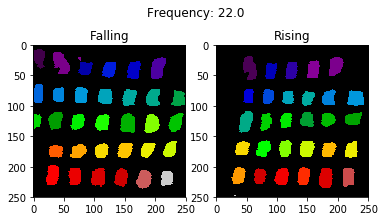


 23%|██▎       | 21/90 [00:15<00:53,  1.30it/s]

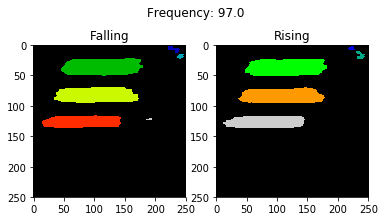


 24%|██▍       | 22/90 [00:16<00:50,  1.34it/s]

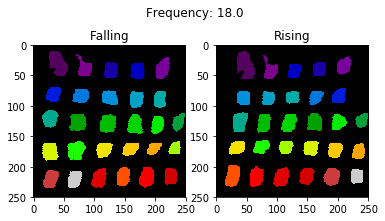


 26%|██▌       | 23/90 [00:17<00:51,  1.31it/s]

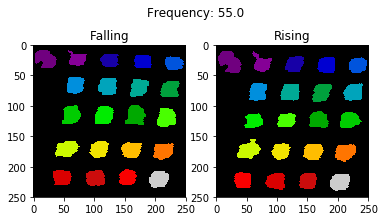


 27%|██▋       | 24/90 [00:17<00:49,  1.32it/s]

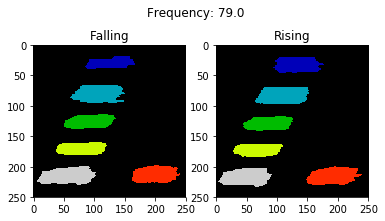


 28%|██▊       | 25/90 [00:18<00:48,  1.33it/s]

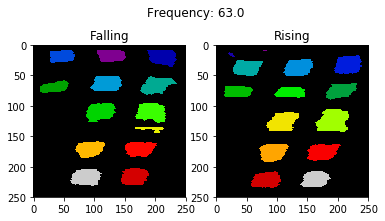


 29%|██▉       | 26/90 [00:19<00:47,  1.34it/s]

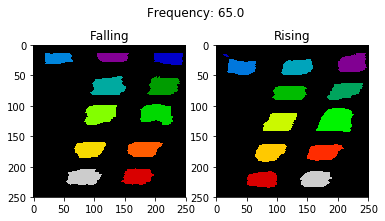


 30%|███       | 27/90 [00:20<00:45,  1.37it/s]

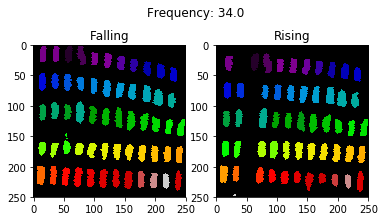


 31%|███       | 28/90 [00:21<00:48,  1.27it/s]

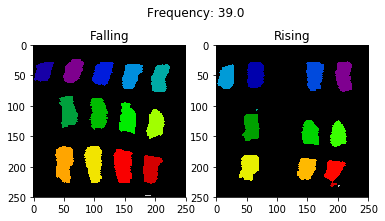


 32%|███▏      | 29/90 [00:21<00:46,  1.31it/s]

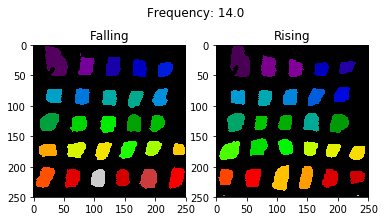


 33%|███▎      | 30/90 [00:22<00:46,  1.29it/s]

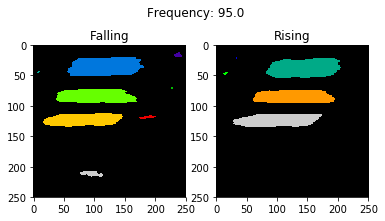


 34%|███▍      | 31/90 [00:23<00:44,  1.34it/s]

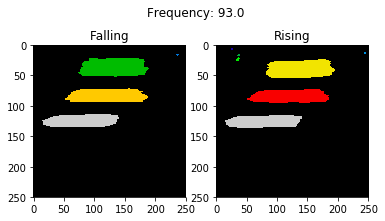


 36%|███▌      | 32/90 [00:23<00:42,  1.37it/s]

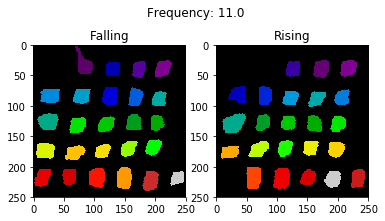


 37%|███▋      | 33/90 [00:24<00:42,  1.35it/s]

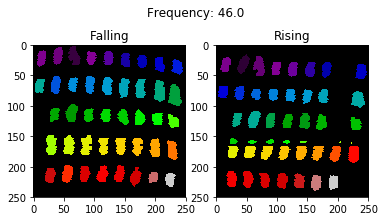


 38%|███▊      | 34/90 [00:25<00:42,  1.31it/s]

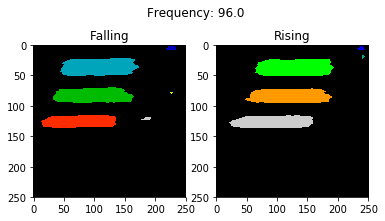


 39%|███▉      | 35/90 [00:26<00:40,  1.35it/s]

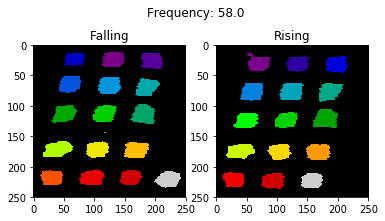


 40%|████      | 36/90 [00:27<00:40,  1.32it/s]

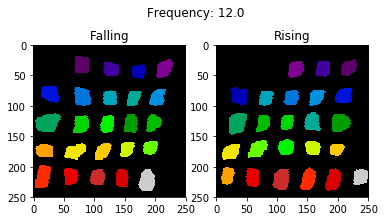


 41%|████      | 37/90 [00:27<00:39,  1.33it/s]

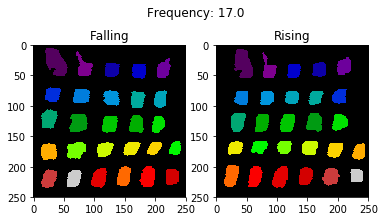


 42%|████▏     | 38/90 [00:28<00:39,  1.31it/s]

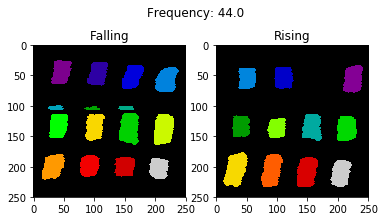


 43%|████▎     | 39/90 [00:29<00:38,  1.33it/s]

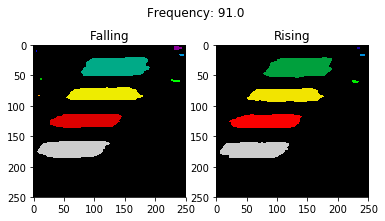


 44%|████▍     | 40/90 [00:29<00:36,  1.36it/s]

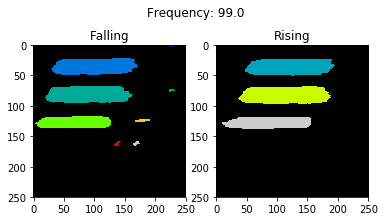


 46%|████▌     | 41/90 [00:30<00:35,  1.39it/s]

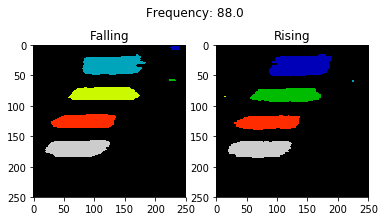


 47%|████▋     | 42/90 [00:31<00:36,  1.31it/s]

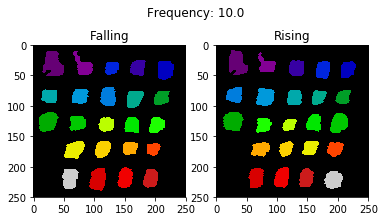


 48%|████▊     | 43/90 [00:32<00:37,  1.25it/s]

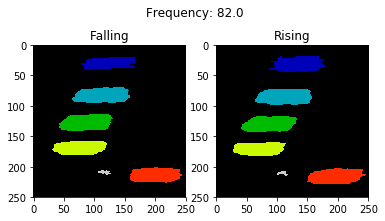


 49%|████▉     | 44/90 [00:33<00:37,  1.23it/s]

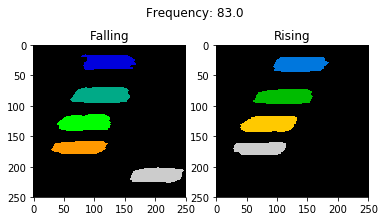


 50%|█████     | 45/90 [00:33<00:35,  1.26it/s]

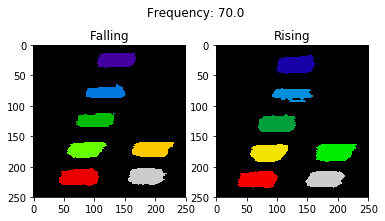


 51%|█████     | 46/90 [00:34<00:35,  1.25it/s]

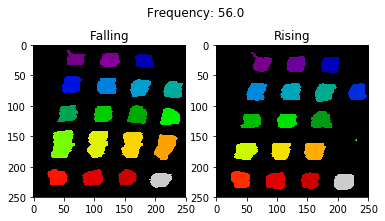


 52%|█████▏    | 47/90 [00:35<00:38,  1.12it/s]

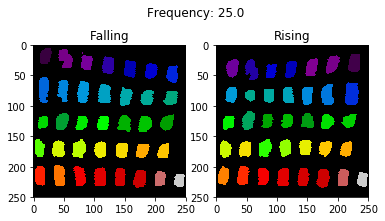


 53%|█████▎    | 48/90 [00:36<00:38,  1.10it/s]

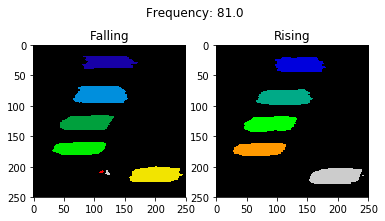


 54%|█████▍    | 49/90 [00:37<00:35,  1.14it/s]

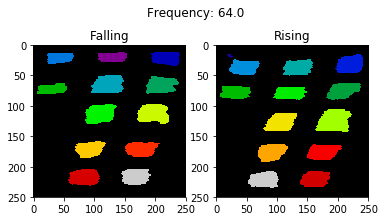


 56%|█████▌    | 50/90 [00:38<00:34,  1.17it/s]

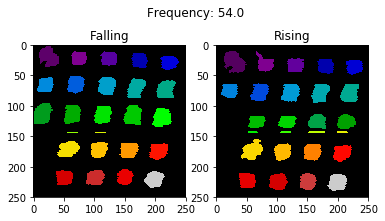


 57%|█████▋    | 51/90 [00:39<00:33,  1.17it/s]

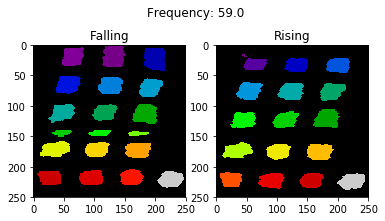


 58%|█████▊    | 52/90 [00:40<00:33,  1.15it/s]

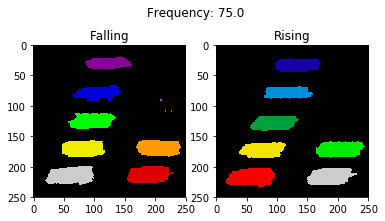


 59%|█████▉    | 53/90 [00:41<00:31,  1.17it/s]

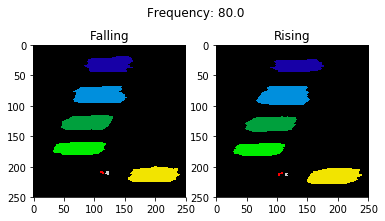


 60%|██████    | 54/90 [00:41<00:30,  1.18it/s]

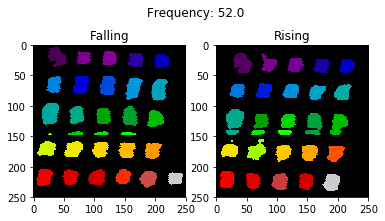


 61%|██████    | 55/90 [00:42<00:30,  1.15it/s]

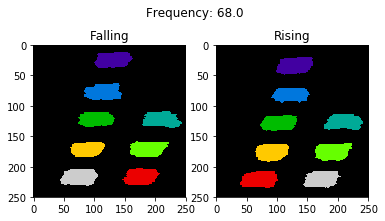


 62%|██████▏   | 56/90 [00:43<00:28,  1.18it/s]

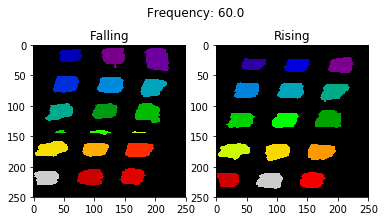


 63%|██████▎   | 57/90 [00:44<00:28,  1.15it/s]

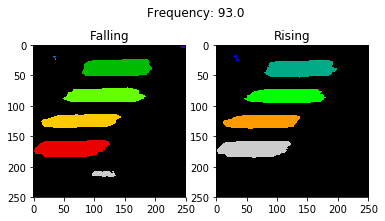


 64%|██████▍   | 58/90 [00:45<00:28,  1.14it/s]

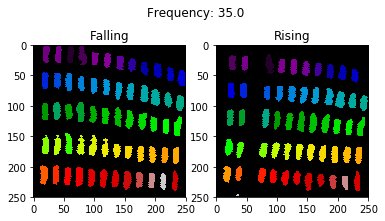


 66%|██████▌   | 59/90 [00:46<00:28,  1.08it/s]

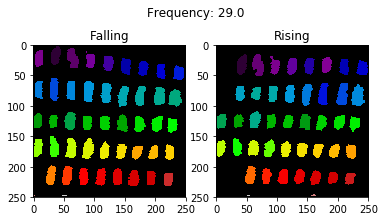


 67%|██████▋   | 60/90 [00:47<00:28,  1.05it/s]

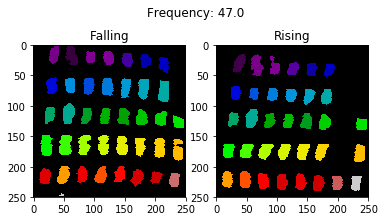


 68%|██████▊   | 61/90 [00:48<00:26,  1.08it/s]

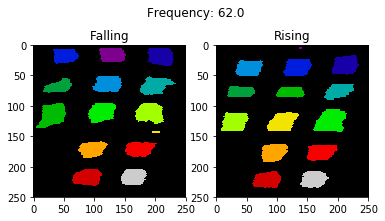


 69%|██████▉   | 62/90 [00:49<00:23,  1.17it/s]

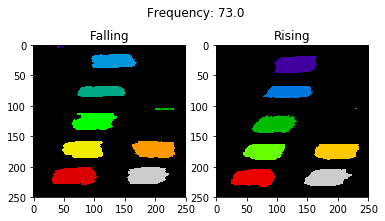


 70%|███████   | 63/90 [00:49<00:21,  1.24it/s]

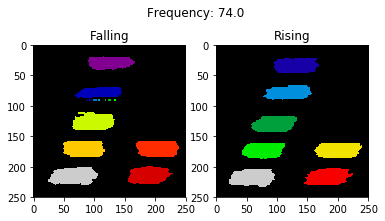


 71%|███████   | 64/90 [00:50<00:20,  1.30it/s]

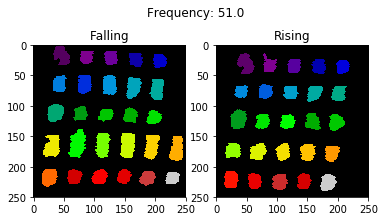


 72%|███████▏  | 65/90 [00:51<00:19,  1.30it/s]

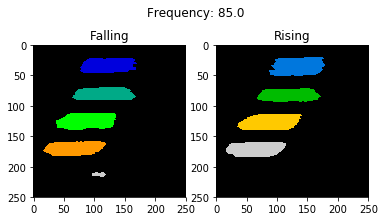


 73%|███████▎  | 66/90 [00:51<00:17,  1.36it/s]

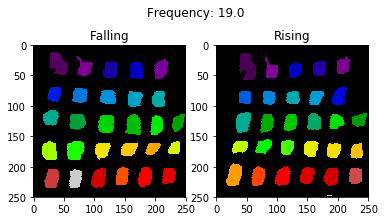


 74%|███████▍  | 67/90 [00:52<00:17,  1.33it/s]

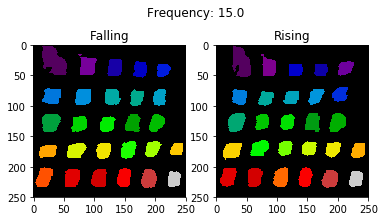


 76%|███████▌  | 68/90 [00:53<00:16,  1.33it/s]

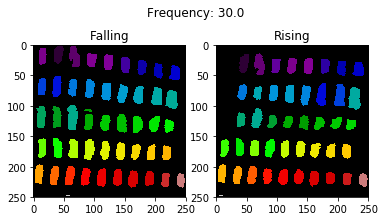


 77%|███████▋  | 69/90 [00:54<00:17,  1.23it/s]

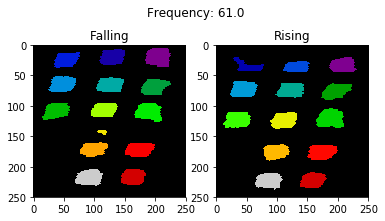


 78%|███████▊  | 70/90 [00:55<00:15,  1.29it/s]

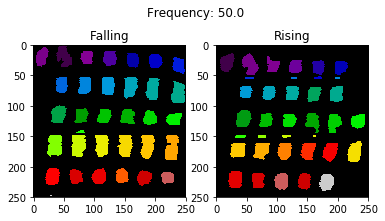


 79%|███████▉  | 71/90 [00:55<00:14,  1.27it/s]

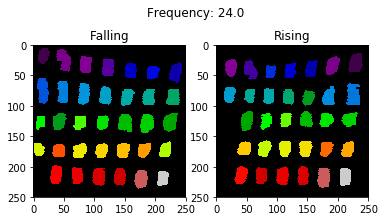


 80%|████████  | 72/90 [00:56<00:14,  1.26it/s]

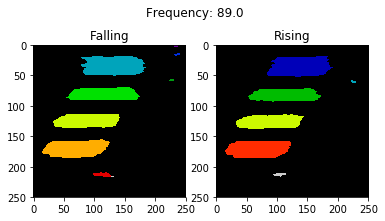


 81%|████████  | 73/90 [00:57<00:12,  1.31it/s]

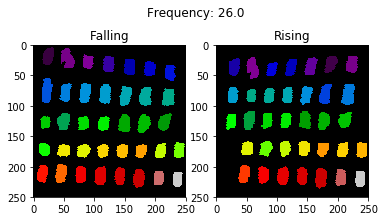


 82%|████████▏ | 74/90 [00:58<00:12,  1.28it/s]

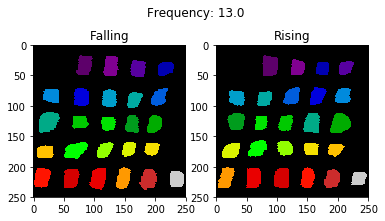


 83%|████████▎ | 75/90 [00:58<00:11,  1.29it/s]

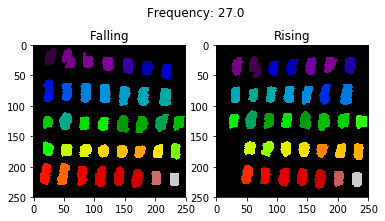


 84%|████████▍ | 76/90 [00:59<00:10,  1.27it/s]

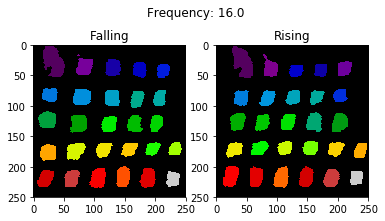


 86%|████████▌ | 77/90 [01:00<00:10,  1.28it/s]

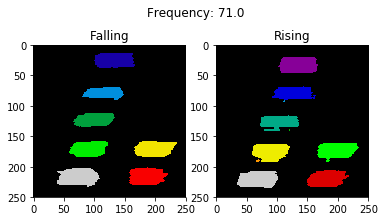


 87%|████████▋ | 78/90 [01:01<00:08,  1.34it/s]

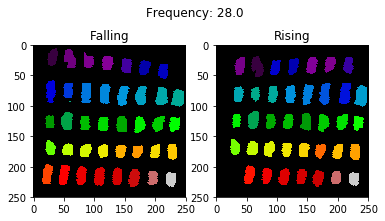


 88%|████████▊ | 79/90 [01:01<00:08,  1.30it/s]

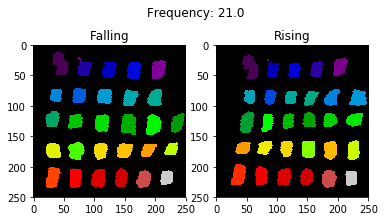


 89%|████████▉ | 80/90 [01:02<00:07,  1.26it/s]

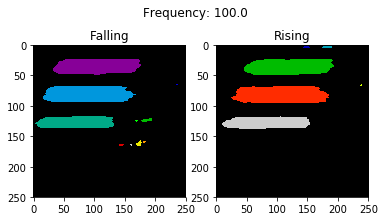


 90%|█████████ | 81/90 [01:03<00:06,  1.31it/s]

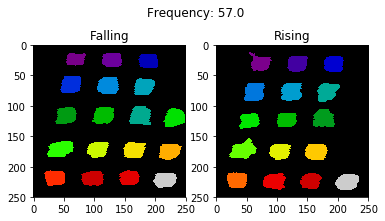


 91%|█████████ | 82/90 [01:04<00:06,  1.33it/s]

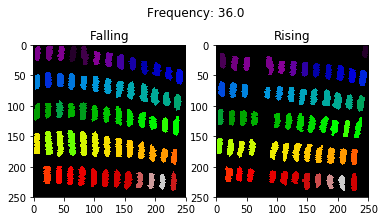


 92%|█████████▏| 83/90 [01:05<00:05,  1.24it/s]

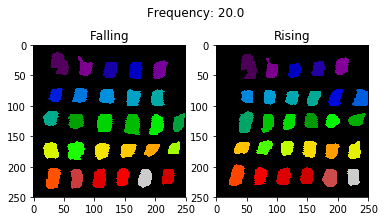


 93%|█████████▎| 84/90 [01:05<00:04,  1.25it/s]

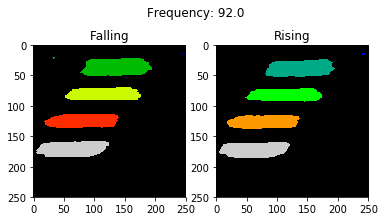


 94%|█████████▍| 85/90 [01:06<00:03,  1.30it/s]

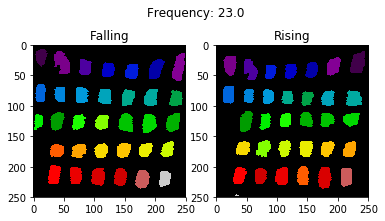


 96%|█████████▌| 86/90 [01:07<00:03,  1.28it/s]

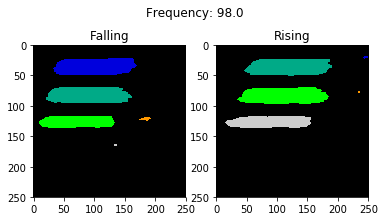


 97%|█████████▋| 87/90 [01:08<00:02,  1.32it/s]

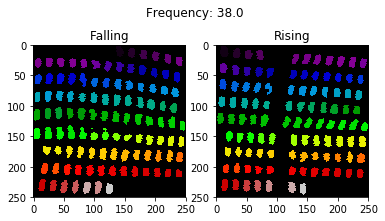


 98%|█████████▊| 88/90 [01:09<00:01,  1.15it/s]

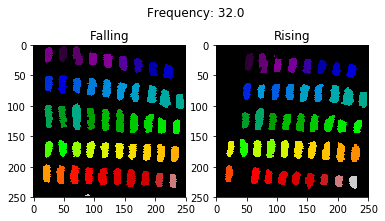


 99%|█████████▉| 89/90 [01:10<00:00,  1.15it/s]

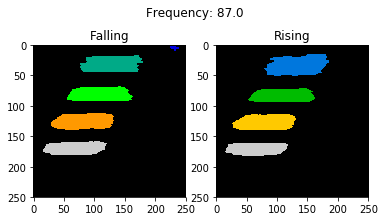


100%|██████████| 90/90 [01:10<00:00,  1.23it/s]

In [4]:
# TODO distances between centers

import glob
import os
import numpy
import matplotlib.pyplot as pyplot
from   skimage.color import rgb2gray
import imageio
import tqdm

import ProcessingFuncs

debugPlotPhase  = False
debugPlotLabels = True

PhysicalCellWidth = 40.2 # Microns, width of cells

def getFastFrequencyAndMagFromPath(newImagePath):
    # Image name format is "Capture_yyyy-mm-dd[hh-mm-ss]_[w1text,w2text](waveform)-[f1,f2](Hz)-[mag1,mag2](Vpp)-[ph1, ph2](2piphase)"
    _, imageTitle = os.path.split(newImagePath)
    titleDateProperties = imageTitle.split('_')
    waveformsFrequenciesMagnitudesPhases = titleDateProperties[2].split('-')
    # Gets frequency 
    frequencies = (waveformsFrequenciesMagnitudesPhases[1])[1:-5].split(',')
    # Gets magnitude
    magnitudes  = (waveformsFrequenciesMagnitudesPhases[2])[1:-6].split(',')
    return (float(frequencies[1]), float(magnitudes[1])) # Note, units are Hz and Vpp
    
# Make sure that the calibration samples are in the right folder!
fileList = glob.glob(os.path.join(os.path.abspath(''), "Captures_Calibration", "*.bmp"))
phaseMagRecords = numpy.zeros((len(fileList), 3))

for latestFileIndex in tqdm.tqdm(range(len(fileList))):
    latestPath         = fileList[latestFileIndex]
    latestFrequency, latestDriveMag = getFastFrequencyAndMagFromPath(latestPath)
    latestImage        = rgb2gray(numpy.rot90(imageio.imread(latestPath)))
    phaseMagRecords[latestFileIndex, 0] = float(latestFrequency) * 2.0 * numpy.pi # We want to store rad/s
    # > Gets Phase
    latestPhase        = ProcessingFuncs.getAssumedTroughPhase(latestImage) % (numpy.pi) - numpy.pi # All multiples of Pi of the phase are crests/ troughs, this is more consistent
    phaseMagRecords[latestFileIndex, 1] = latestPhase
    # > Gets magnitude
    imRising, imFalling = ProcessingFuncs.resampleVerticalDistortion(latestImage, latestPhase)
    labeledImage_rising, numObjects_rising = ProcessingFuncs.isolateAndLabelNonOcccluded(imRising)
    labeledImage_falling, numObjects_falling = ProcessingFuncs.isolateAndLabelNonOcccluded(imFalling)
    averageCellWidthPixels = float(numpy.mean(numpy.concatenate(ProcessingFuncs.getLabelWidthCounts(labeledImage_rising, numObjects_rising) + ProcessingFuncs.getLabelWidthCounts(labeledImage_falling, numObjects_falling))))
    micronsPerPixel        = float(PhysicalCellWidth) / averageCellWidthPixels
    totalWidthMicrons      = micronsPerPixel * latestImage.shape[1]
    phaseMagRecords[latestFileIndex, 2] = (totalWidthMicrons) / float(latestDriveMag) # Note that magnitude of output sine wave is half of total width of image, magnitude of input is half of vpp value, but these cancel out
    
    # ----------- Plotting for Verification -----------
    if(debugPlotPhase == True):
        maxIndex = (latestPhase / (2.0 * numpy.pi)) * max(latestImage.shape)
        pyplot.imshow(latestImage, cmap= pyplot.cm.gray, zorder = 1)
        _, imageTitle = os.path.split(latestPath)
        pyplot.title('Target Image %s' % (imageTitle))
        ymin, ymax = pyplot.gca().get_ybound()
        pyplot.plot([maxIndex, maxIndex], [ymin, ymax], color = 'fireBrick', zorder = 2)
        pyplot.show()
        
    if(debugPlotLabels == True):
        fig, axis = pyplot.subplots(1, 2)
        fig.suptitle('Frequency: %s' % latestFrequency, y = 0.9)
        axis[0].set_title('Falling')
        axis[0].imshow(labeledImage_falling, pyplot.cm.nipy_spectral)
        axis[1].set_title('Rising')
        axis[1].imshow(labeledImage_rising, cmap= pyplot.cm.nipy_spectral)
        pyplot.show()

You can see the data plotted below. 
<br>
<br>
For the data collected for the OIS stage the results clearly indicated that the system was second order with complex poles so to estimate parameters for the system I just used an optimization algorithm to fit to the frequency domain data. 
<br>
<br>
However, generally we would want to use a package and algorithms like https://github.com/CPCLAB-UNIPI/SIPPY to identify the characteristic function of our system. These packages are intended for time domain analysis but could probably be used for frequency domain data if we processed our frequency domain data.

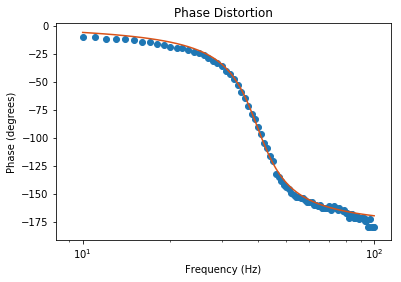

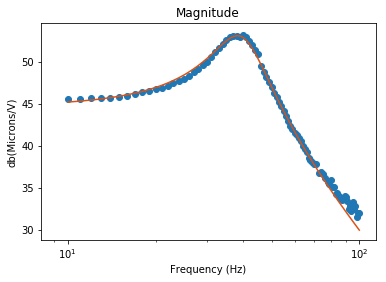

Identified Parameters: Natural Frequency 249.4626, 39.7032 (Rad/S), (Hz), DC Gain 171.1344 (Microns/v), Damping Ratio 0.1932


In [35]:
import lmfit
import os
from numpy.lib import scimath

# Converts data to complex valued
complexRecords = numpy.zeros((phaseMagRecords.shape[0], 2), dtype=numpy.complex_)
complexRecords[:, 0] = phaseMagRecords[:, 0]
complexRecords[:, 1] = phaseMagRecords[:, 2] * numpy.exp(1j * phaseMagRecords[:, 1])

# Tries to optimize best guess for second order fit
def model(frequencies, naturalFrequency, magnitude, dampRatio):
    return magnitude * ((numpy.ones(frequencies.shape) * naturalFrequency**2) / ((frequencies * 1j)**2 + frequencies * 1j * naturalFrequency * dampRatio * 2 + naturalFrequency**2))

def complexResidual(params, x, data):
    naturalFreq = params['NaturalFreq']
    dcGain   = params['DCGain']
    dampRatio   = params['DampRatio']
    return (data - model(x, naturalFreq, dcGain, dampRatio)).view(numpy.float)
    
params = lmfit.Parameters()
params.add('NaturalFreq', value = 28 * 2 * numpy.pi) # Best guess from bode
params.add('DCGain', value = numpy.absolute(complexRecords[0, 1]))
params.add('DampRatio', value = 0.1)

minimizedVals = lmfit.minimize(complexResidual, params, args = (complexRecords[:, 0], complexRecords[:, 1]))

# Plots bode plot with fit
sortedFrequencies = numpy.sort(numpy.absolute(complexRecords[:, 0]))
foundNatFreq   = minimizedVals.params['NaturalFreq'].value
foundDCGain = minimizedVals.params['DCGain'].value
foundDampRatio = minimizedVals.params['DampRatio'].value
fitEstimate = model(sortedFrequencies, foundNatFreq, foundDCGain,  foundDampRatio)

pyplot.plot(sortedFrequencies / (2.0 * numpy.pi), numpy.degrees(numpy.angle(fitEstimate)), c = '#d95319')
pyplot.scatter(complexRecords[:, 0] / (2.0 * numpy.pi), numpy.degrees(numpy.angle(complexRecords[:, 1])))
pyplot.title("Phase Distortion")
pyplot.xlabel('Frequency (Hz)')
pyplot.ylabel('Phase (degrees)')
pyplot.xscale('log')
pyplot.show()

pyplot.plot(sortedFrequencies / (2.0 * numpy.pi), 20 * numpy.log10(numpy.absolute(fitEstimate)), c = '#d95319')
pyplot.scatter(complexRecords[:, 0] / (2.0 * numpy.pi), 20 * numpy.log10(numpy.absolute(complexRecords[:, 1])))
pyplot.title("Magnitude")
pyplot.xlabel('Frequency (Hz)')
pyplot.ylabel('db(Microns/V)')
pyplot.xscale('log')
pyplot.show()

print("Identified Parameters: Natural Frequency %0.4f, %0.4f (Rad/S), (Hz), DC Gain %0.4f (Microns/v), Damping Ratio %0.4f" % (foundNatFreq, foundNatFreq / (2.0 * numpy.pi), foundDCGain, foundDampRatio))

# Saves data to file
Gain = [foundDCGain * foundNatFreq**2] # Note that found gain is DC gain, we need to divide this by 
Zeros      = []
Poles      = [-1 * foundDampRatio * foundNatFreq + foundNatFreq * scimath.sqrt(foundDampRatio**2 - 1), -1 * foundDampRatio * foundNatFreq - foundNatFreq * scimath.sqrt(foundDampRatio**2 - 1)]
TransferFunc = {'Gain': Gain, 'Zeros': Zeros, 'Poles': Poles}

savePath = os.path.join(os.getcwd(), 'TransFunc_OIS.txt')
fileToMod = open(savePath,"w")
fileToMod.write(str(TransferFunc))
fileToMod.close()